In [2]:
import pandas as pd
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import os
import sys
import math
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

import distribution_inference.datasets.utils as utils

/sfs/gpfs/tardis/home/ujx4ab/ondemand/dissecting_dist_inf/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
WT = ["01", "06", "07", "11"]
DATA_FOLDER = "/sfs/gpfs/tardis/home/ujx4ab/ondemand/dissecting_dist_inf/datasets/LSTM_WTs/data_prep/"

# Load and concatenate all the dataframes
dfs = []
for wt in WT:
    path = DATA_FOLDER + f"EDP_WT_{wt}.csv"
    df_wt = pd.read_csv(path)
    dfs.append(df_wt)

# Combine all into one DataFrame
df = pd.concat(dfs, ignore_index=True)
print(df.columns)
print(len(df.columns))

Index(['Timestamp', 'Wind_speed', 'Wind_speed_std', 'Wind_rel_dir', 'Amb_temp',
       'Gen_speed', 'Gen_speed_std', 'Rotor_speed', 'Rotor_speed_std',
       'Blade_pitch', 'Blade_pitch_std', 'Gen_phase_temp_1',
       'Gen_phase_temp_2', 'Gen_phase_temp_3', 'Transf_temp_p1',
       'Transf_temp_p2', 'Transf_temp_p3', 'Hyd_oil_temp', 'Gear_oil_temp',
       'Gear_bear_temp', 'Nacelle_position', 'Power', 'Wind_rel_dir_cos',
       'Wind_rel_dir_sin', 'Nacelle_position_cos', 'Nacelle_position_sin',
       'Gen_bear_temp_avg'],
      dtype='object')
27


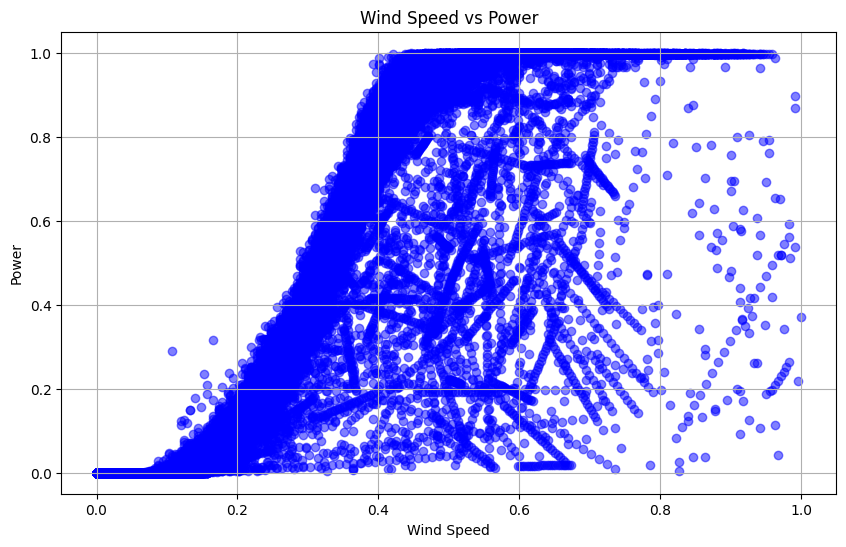

In [3]:
# Plot Wind_speed vs Power
plt.figure(figsize=(10, 6))
plt.scatter(df['Wind_speed'], df['Power'], alpha=0.5, c='b', marker='o')
plt.title('Wind Speed vs Power')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.grid(True)
plt.show()


Sigmoid Parameters:
  L   = 0.231
  x0  = 0.542
  k   = 16.453
  b   = 0.007

Linear Coefficients:
[ 0.35942834 -0.09085572]

Quadratic Coefficients:
[ 1.04238884 -0.50783492  0.06965397]

Cubic Coefficients:
[-2.32564044  4.29278225 -1.8955772   0.24969405]


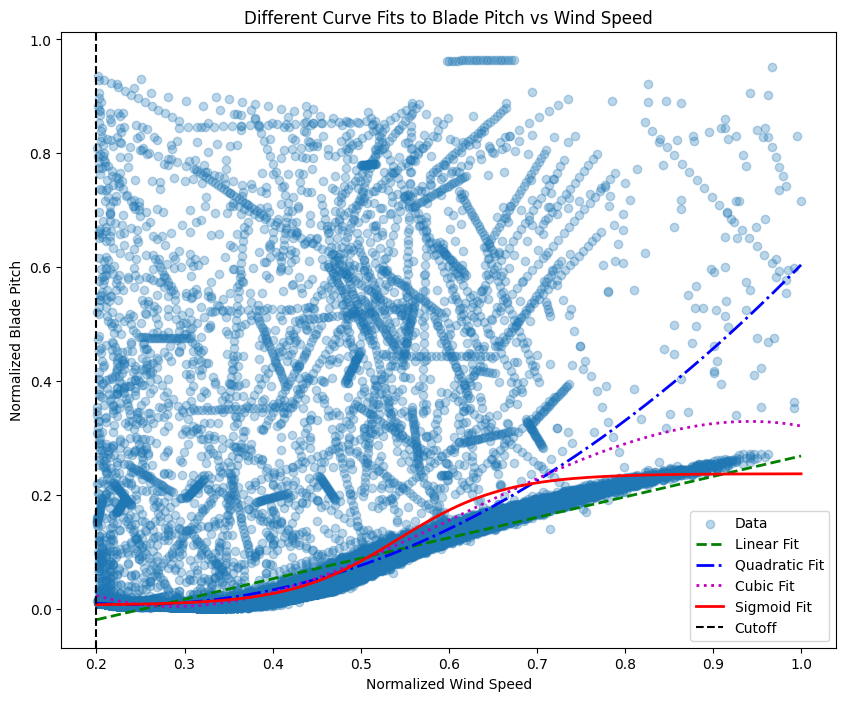

In [4]:
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

df_filtered = df[df['Wind_speed'] > 0.2].copy()
x_data = df_filtered['Wind_speed'].values
y_data = df_filtered['Blade_pitch'].values

# sigmoid fit
initial_guesses = [1.0, 0.5, 10.0, 0.0]
popt, pcov = curve_fit(sigmoid, x_data, y_data, p0=initial_guesses)
L_opt, x0_opt, k_opt, b_opt = popt
x_fit = np.linspace(x_data.min(), x_data.max(), 200)
y_sigmoid = sigmoid(x_fit, L_opt, x0_opt, k_opt, b_opt)
print("\nSigmoid Parameters:")
print(f"  L   = {L_opt:.3f}")
print(f"  x0  = {x0_opt:.3f}")
print(f"  k   = {k_opt:.3f}")
print(f"  b   = {b_opt:.3f}")

# linear fit
linear_coeffs = np.polyfit(x_data, y_data, 1)
linear_fit = np.poly1d(linear_coeffs)
y_linear = linear_fit(x_fit)
print("\nLinear Coefficients:")
print(linear_coeffs)

# quadrati fit
quad_coeffs = np.polyfit(x_data, y_data, 2)
quad_fit = np.poly1d(quad_coeffs)
y_quad = quad_fit(x_fit)
print("\nQuadratic Coefficients:")
print(quad_coeffs)

# cubic fit
cubic_coeffs = np.polyfit(x_data, y_data, 3)
cubic_fit = np.poly1d(cubic_coeffs)
y_cubic = cubic_fit(x_fit)
print("\nCubic Coefficients:")
print(cubic_coeffs)


plt.figure(figsize=(10, 8))
plt.scatter(x_data, y_data, alpha=0.3, label='Data')
plt.plot(x_fit, y_linear, 'g--', lw=2, label='Linear Fit')
plt.plot(x_fit, y_quad, 'b-.', lw=2, label='Quadratic Fit')
plt.plot(x_fit, y_cubic, 'm:', lw=2, label='Cubic Fit')
plt.plot(x_fit, y_sigmoid, 'r-', lw=2, label='Sigmoid Fit')

plt.axvline(x=0.2, color='k', linestyle='--', label='Cutoff')
plt.xlabel('Normalized Wind Speed')
plt.ylabel('Normalized Blade Pitch')
plt.title('Different Curve Fits to Blade Pitch vs Wind Speed')
plt.legend()
plt.show()

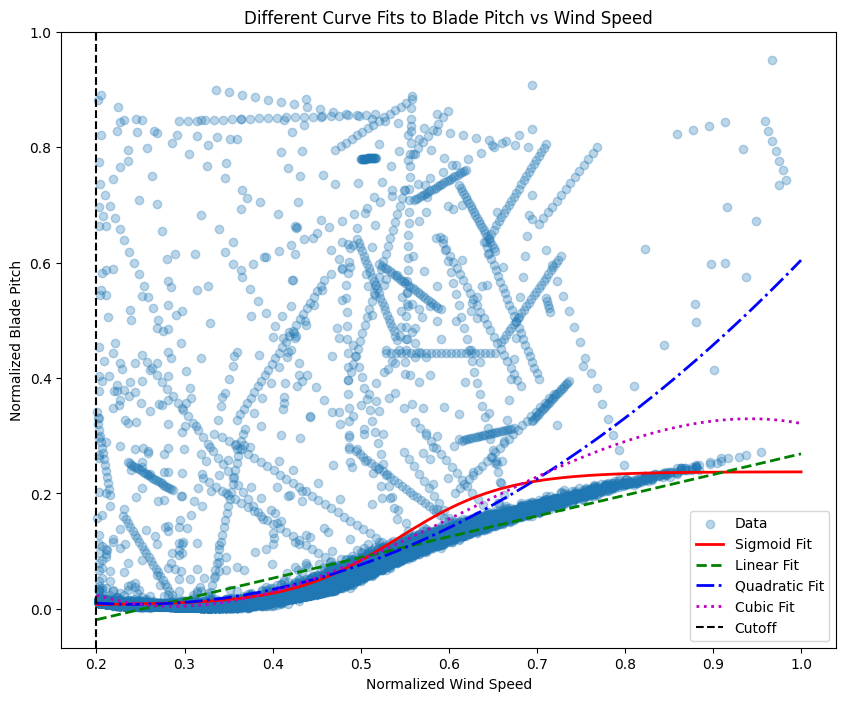

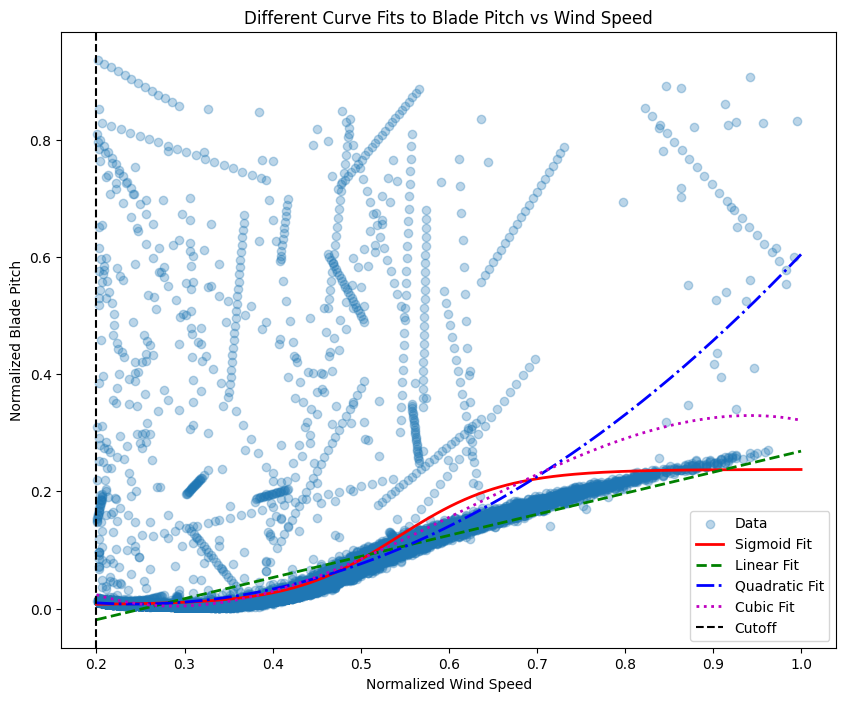

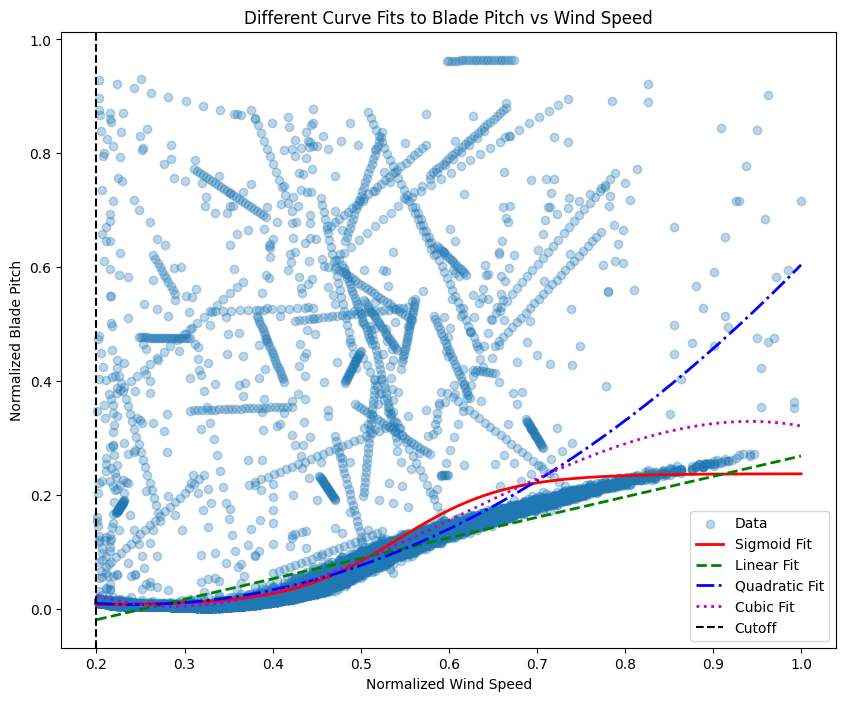

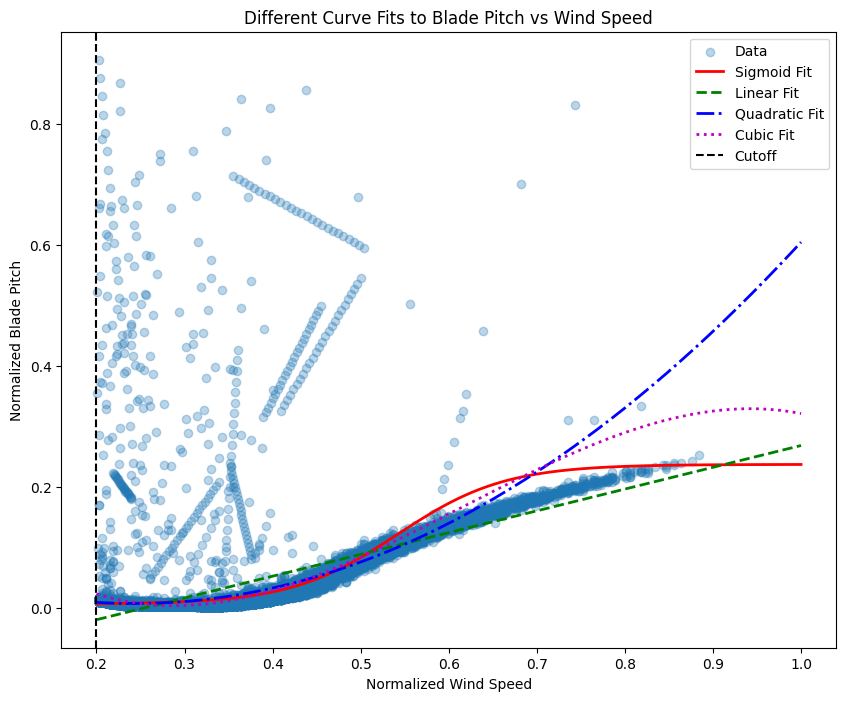

In [5]:
for WT in dfs:
    df_filtered = WT[WT['Wind_speed'] > 0.2].copy()
    x_data = df_filtered['Wind_speed'].values
    y_data = df_filtered['Blade_pitch'].values


    plt.figure(figsize=(10, 8))
    plt.scatter(x_data, y_data, alpha=0.3, label='Data')
    plt.plot(x_fit, y_sigmoid, 'r-', lw=2, label='Sigmoid Fit')
    plt.plot(x_fit, y_linear, 'g--', lw=2, label='Linear Fit')
    plt.plot(x_fit, y_quad, 'b-.', lw=2, label='Quadratic Fit')
    plt.plot(x_fit, y_cubic, 'm:', lw=2, label='Cubic Fit')

    plt.axvline(x=0.2, color='k', linestyle='--', label='Cutoff')
    plt.xlabel('Normalized Wind Speed')
    plt.ylabel('Normalized Blade Pitch')
    plt.title('Different Curve Fits to Blade Pitch vs Wind Speed')
    plt.legend()
    plt.show()

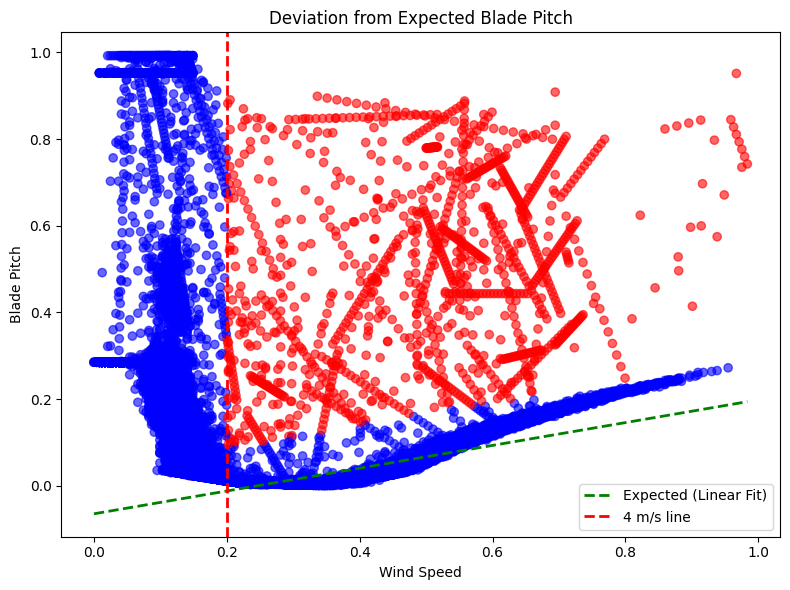

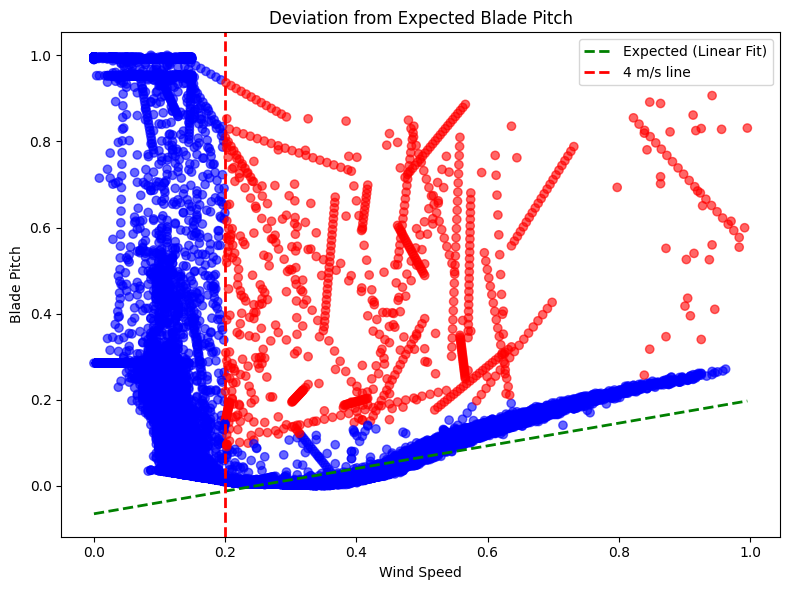

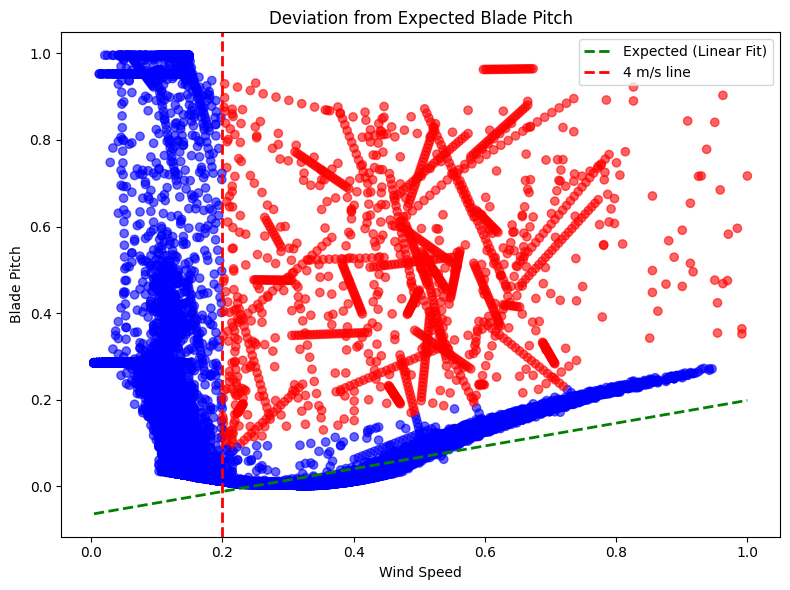

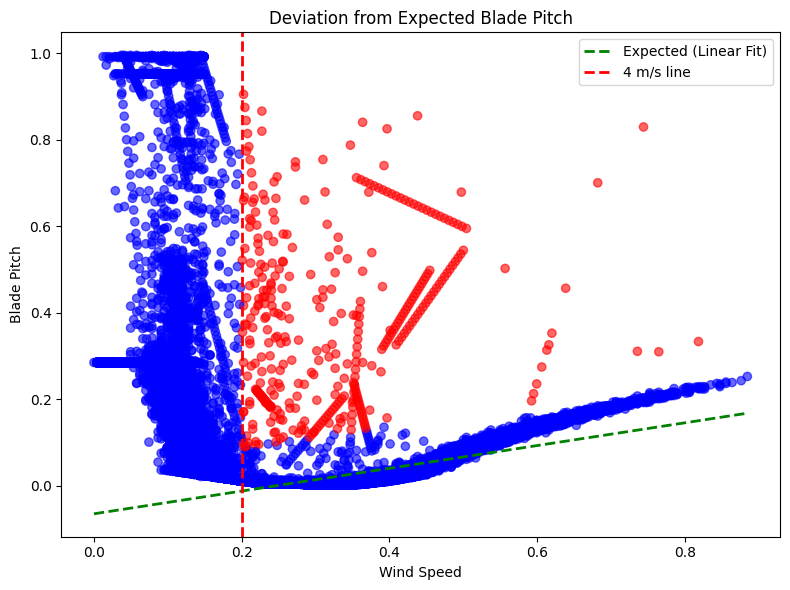

In [18]:
def plot_blade_pitch_deviation(dfs, linear_fit, threshold=2.0):
    for WT in dfs:
        wind_speed = WT['Wind_speed'].values
        blade_pitch = WT['Blade_pitch'].values

        original_wind_speed = 5
        wind_speed_min = 0
        wind_speed_max = 25
        normalized_vertical_line = (original_wind_speed - wind_speed_min) / (wind_speed_max - wind_speed_min)

        expected_blade_pitch = linear_fit(wind_speed)
        abs_diff = np.abs(expected_blade_pitch - blade_pitch)

        colors = np.where(
            wind_speed < normalized_vertical_line, 
            'blue', 
            np.where(abs_diff > threshold, 'red', 'blue')
        )

        plt.figure(figsize=(8, 6))
        plt.scatter(wind_speed, blade_pitch, c=colors, alpha=0.6)
        plt.plot(np.sort(wind_speed), linear_fit(np.sort(wind_speed)), 'g--', label='Expected (Linear Fit)', linewidth=2)

        plt.axvline(normalized_vertical_line, color='red', linestyle='--', linewidth=2, label='4 m/s line')

        plt.xlabel('Wind Speed')
        plt.ylabel('Blade Pitch')
        plt.title('Deviation from Expected Blade Pitch')
        plt.legend()
        plt.tight_layout()
        plt.show()

# After your linear fit
linear_coeffs = np.polyfit(x_data, y_data, 1)
linear_fit = np.poly1d(linear_coeffs)

# Then plot deviations
plot_blade_pitch_deviation(dfs, linear_fit, threshold=0.1)

In [4]:
vertical_line = 4.5/25
threshold = 0.1
for idx, WT in enumerate(dfs):
    wind_speed = WT['Wind_speed'].values
    blade_pitch = WT['Blade_pitch'].values

    expected_blade_pitch = linear_fit(wind_speed)
    abs_diff = np.abs(expected_blade_pitch - blade_pitch)

    condition = (wind_speed > vertical_line) & (abs_diff > threshold)

    proportion = np.mean(condition)

    print(f"Wind Turbine {idx}: {proportion*100:.2f}%")

NameError: name 'linear_fit' is not defined

In [ ]:
for idx, WT in enumerate(dfs):
    wind_speed = WT['Wind_speed'].values
    blade_pitch = WT['Blade_pitch'].values
    print(wind_speed.shape)

NameError: name 'dfs' is not defined

In [8]:
sum(df['Blade_pitch'] < 5.0)/len(df)

0.9872938516491868

In [9]:
if pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
    print("The column is already a datetime type.")
else: 
    print("The column is not a datetime type. Converting it...")
    # Convert to datetime if needed
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])


The column is not a datetime type. Converting it...


In [10]:
# Extract Month from the timestamp
df['Month'] = df['Timestamp'].dt.month

# Map months to seasons
seasons_dict = {
    1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn',
    11: 'Autumn', 12: 'Winter'
}
df['Seasons'] = df['Month'].map(seasons_dict)

# Extract Hour from the timestamp
df['Hour'] = df['Timestamp'].dt.hour + 1
pd.set_option('display.max_columns', None)

KeyError: 'Gen_bearing_temp_1'

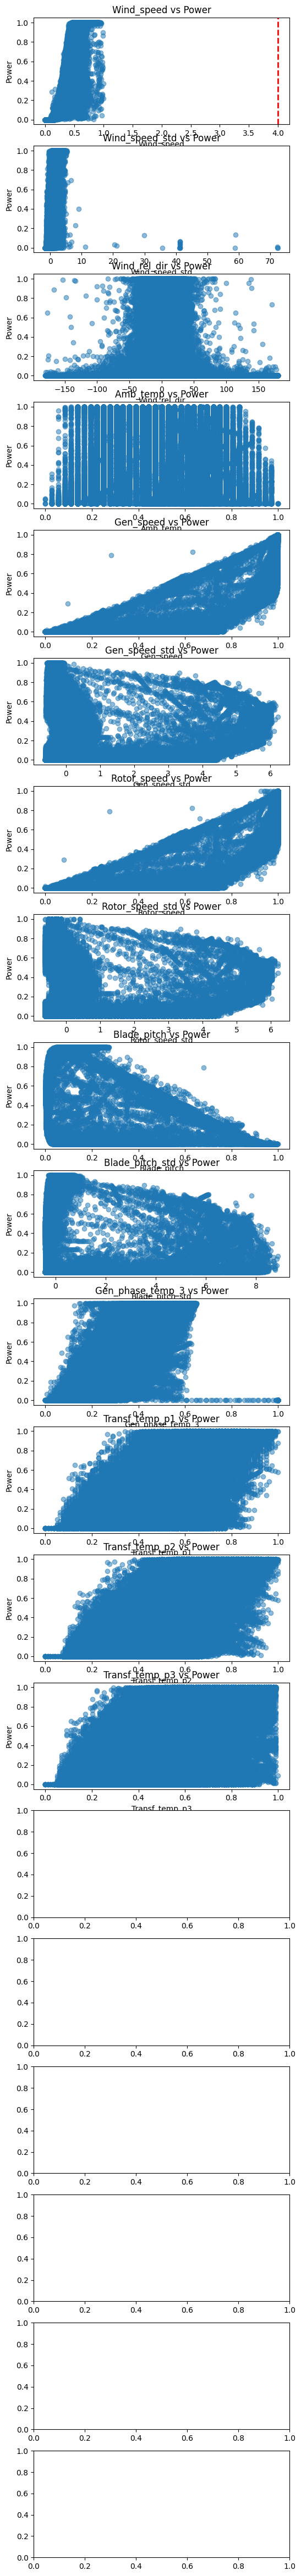

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# List of independent variables to plot against 'Power'
num_col = ['Wind_speed', 'Wind_speed_std', 'Wind_rel_dir', 'Amb_temp',
           'Gen_speed', 'Gen_speed_std', 'Rotor_speed', 'Rotor_speed_std',
           'Blade_pitch', 'Blade_pitch_std', 'Gen_phase_temp_3', 'Transf_temp_p1',
           'Transf_temp_p2', 'Transf_temp_p3', 'Gen_bearing_temp_1',
           'Gen_bearing_temp_2', 'Hyd_oil_temp', 'Gear_oil_temp', 'Gear_bear_temp',
           'Nacelle_position']

# Create the scatter plots for each variable vs 'Power'
fig, axes = plt.subplots(len(num_col), 1, figsize=(6, 3 * len(num_col)))  # Adjust height

# Define vertical line value for wind speed
vertical_line_value = 4  # for Wind Speed

# Iterate through the variables and create scatter plots
for i, col in enumerate(num_col):
    ax = axes[i]  # Get the individual axis
    ax.scatter(df[col], df['Power'], alpha=0.5)
    ax.set_xlabel(col)
    ax.set_ylabel('Power')
    ax.set_title(f'{col} vs Power')
    
    # Add vertical line at Wind_speed value of 4 only for Wind_speed column
    if col == 'Wind_speed':
        ax.axvline(vertical_line_value, color='red', linestyle='--', linewidth=2)

plt.tight_layout(h_pad=3)  # Increase the space between subplots for readability
plt.show()


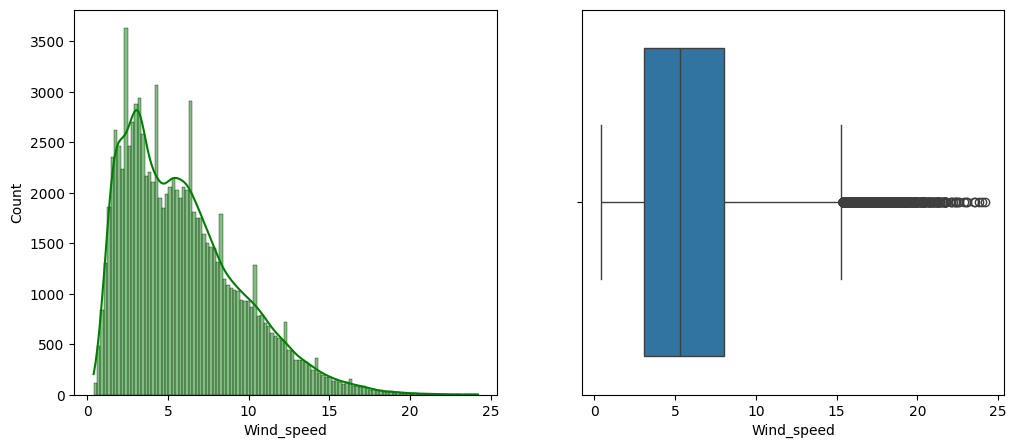

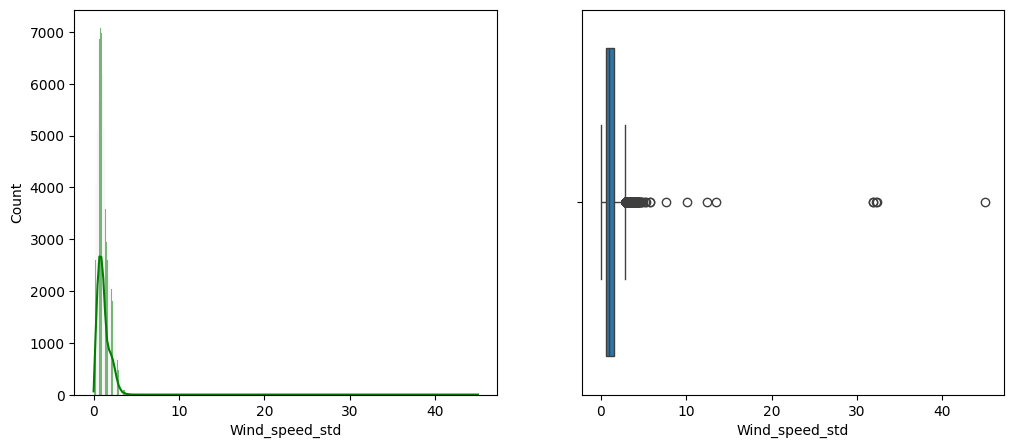

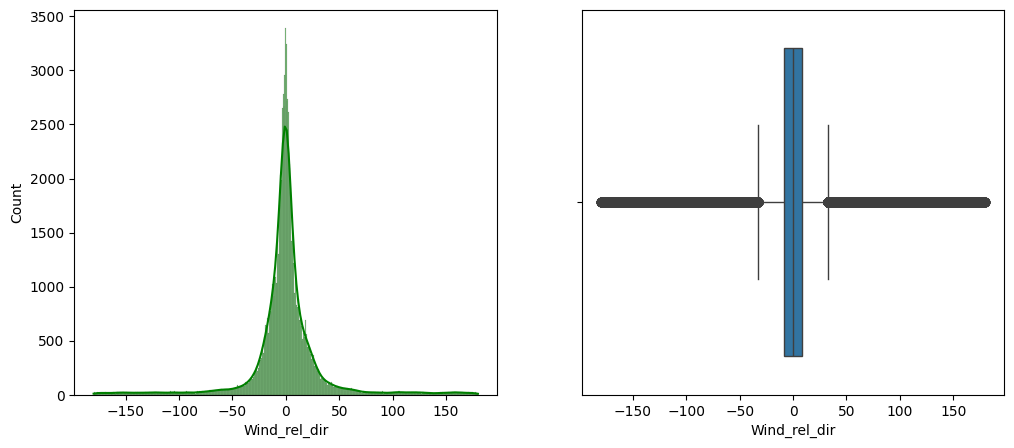

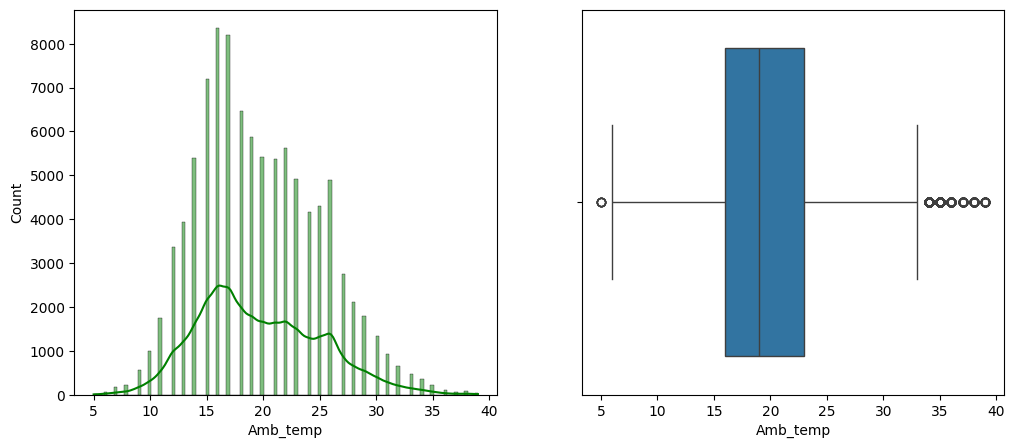

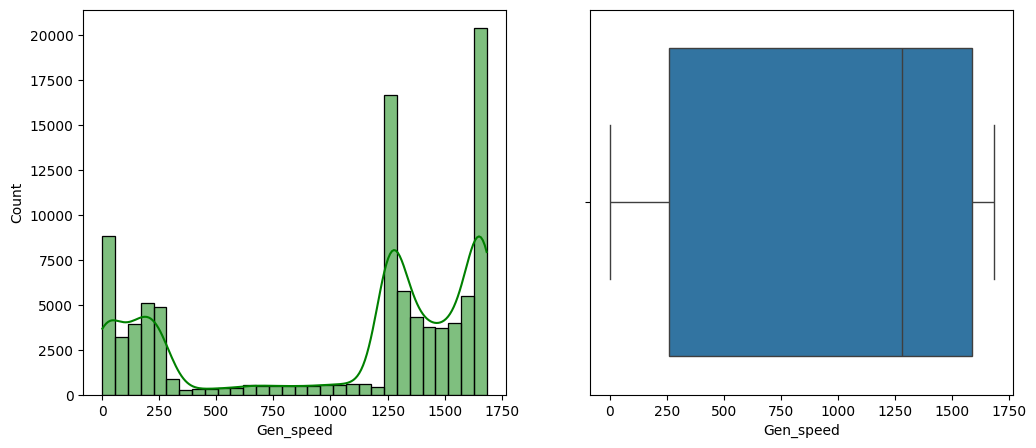

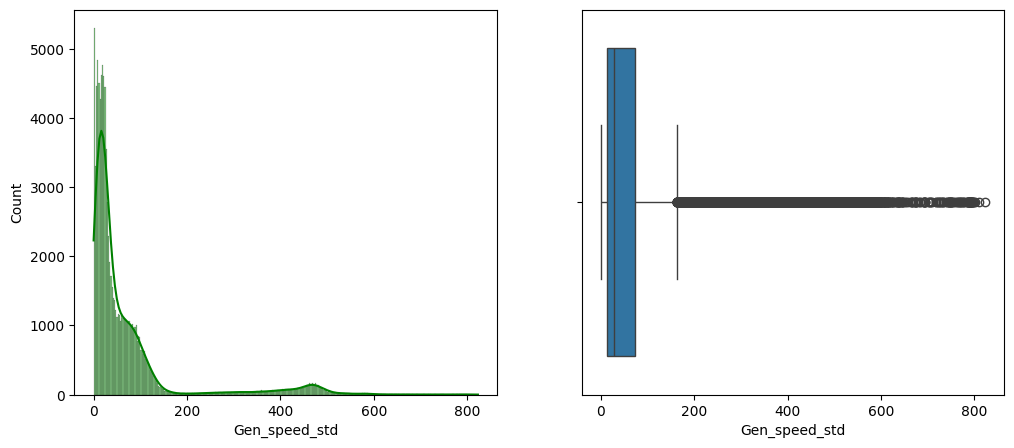

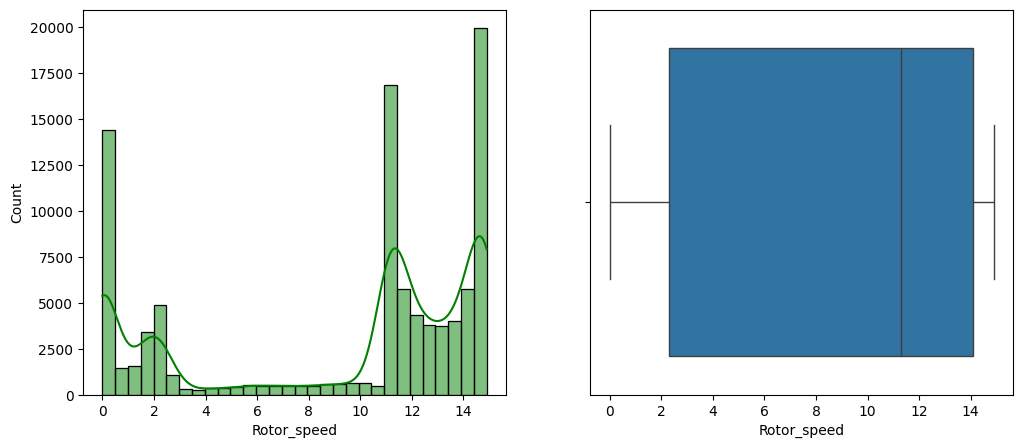

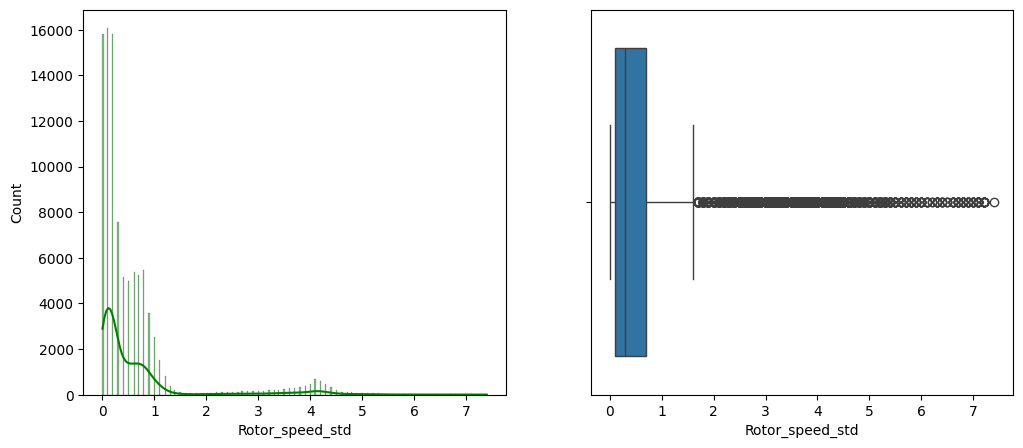

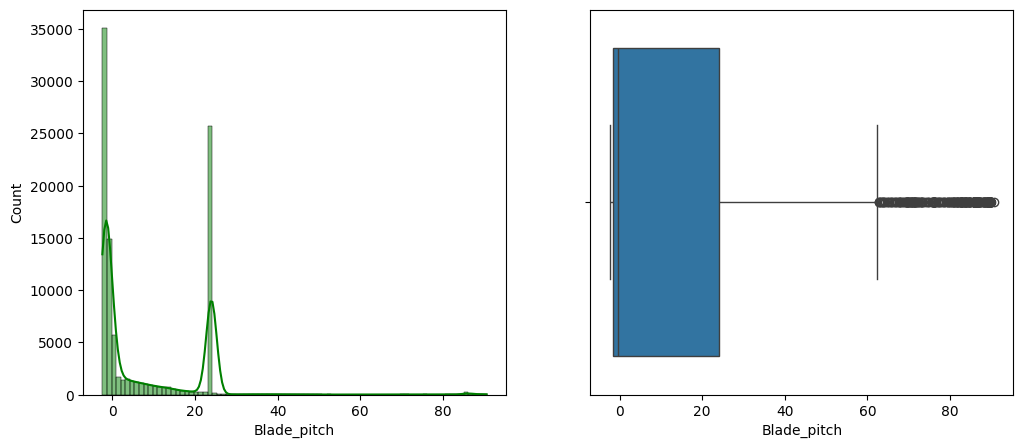

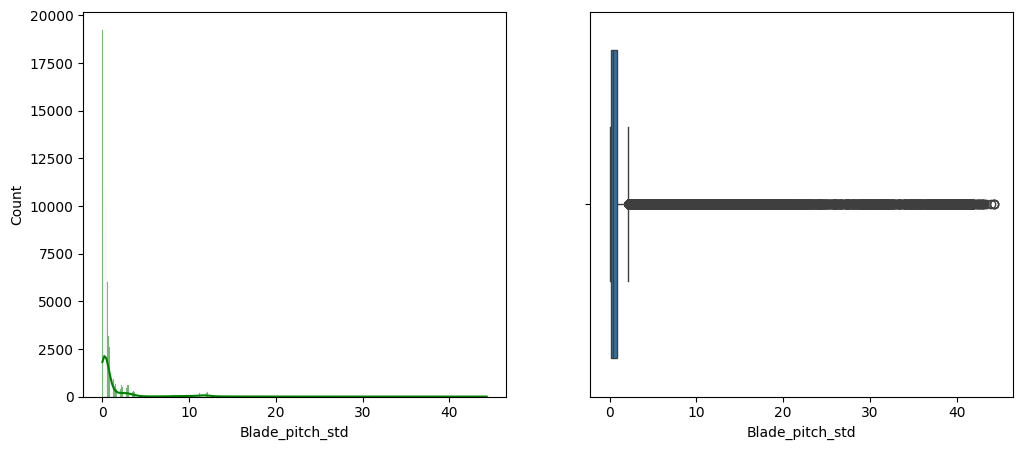

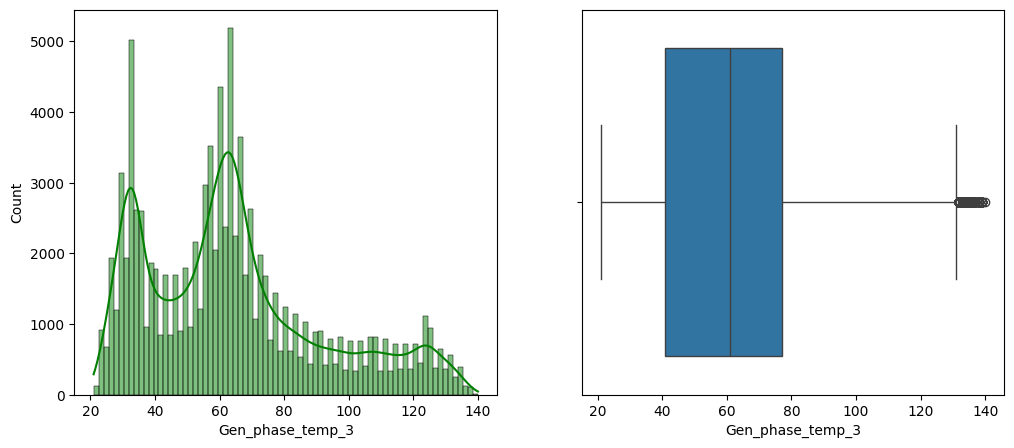

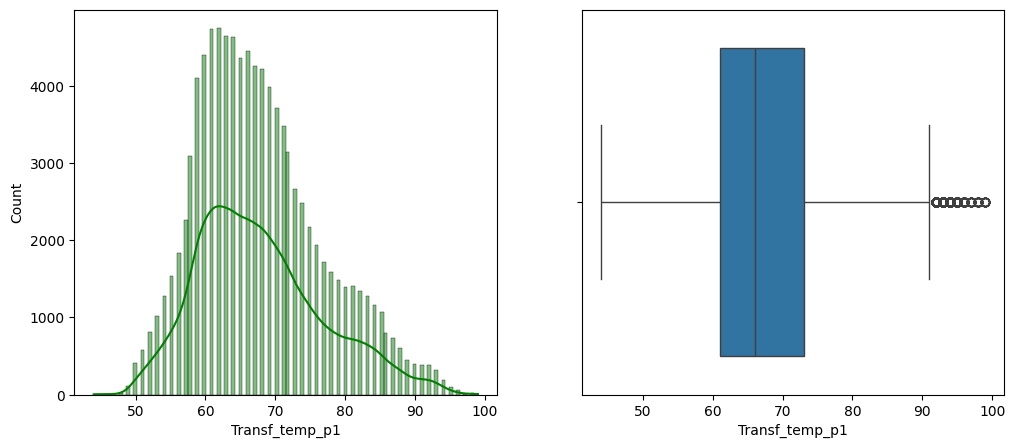

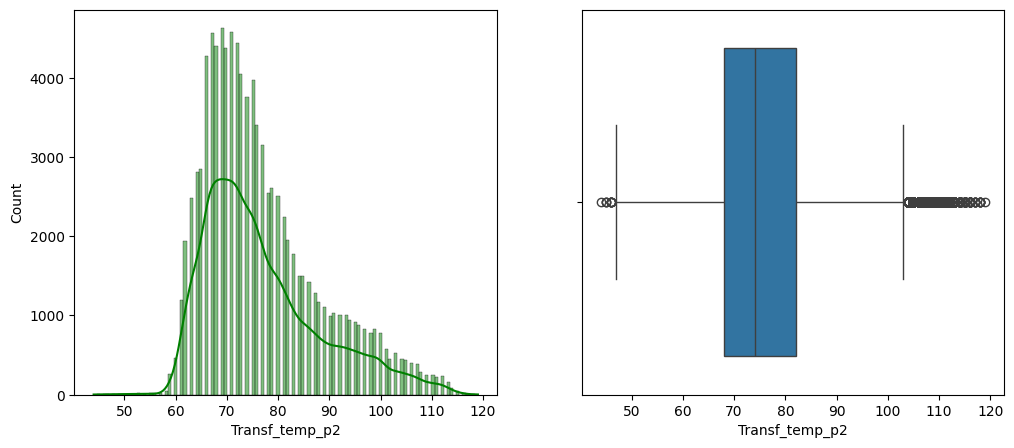

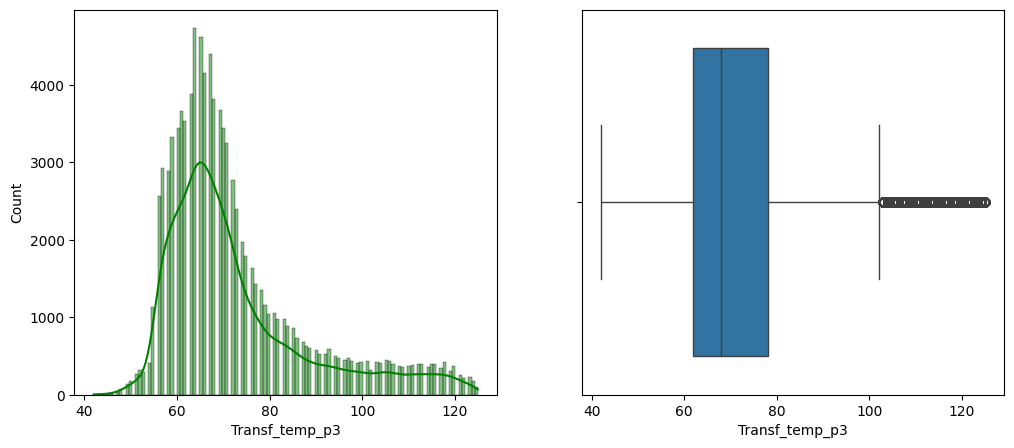

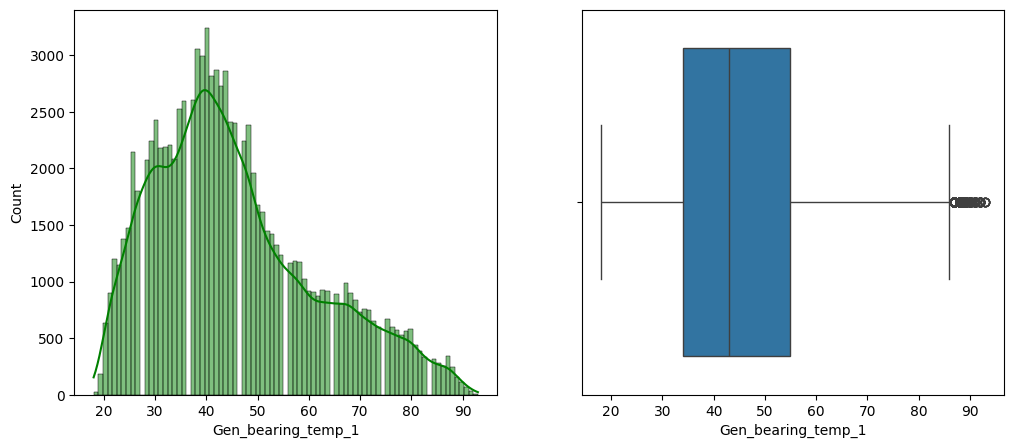

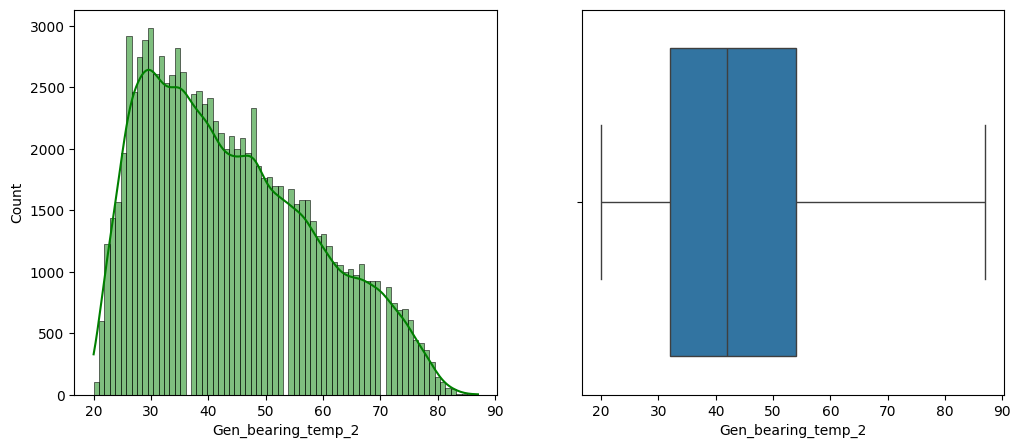

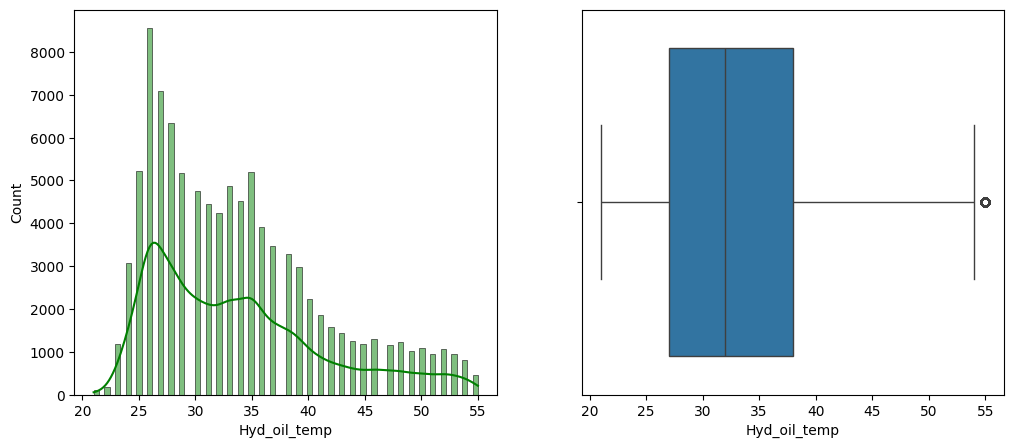

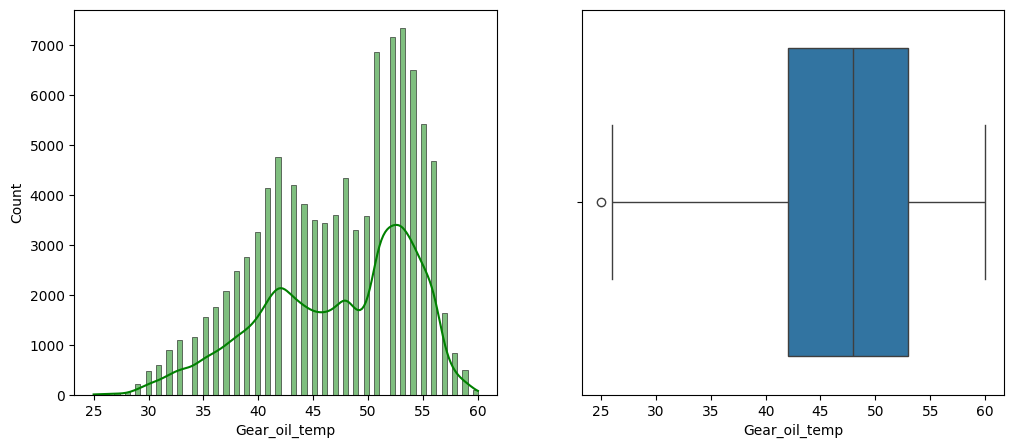

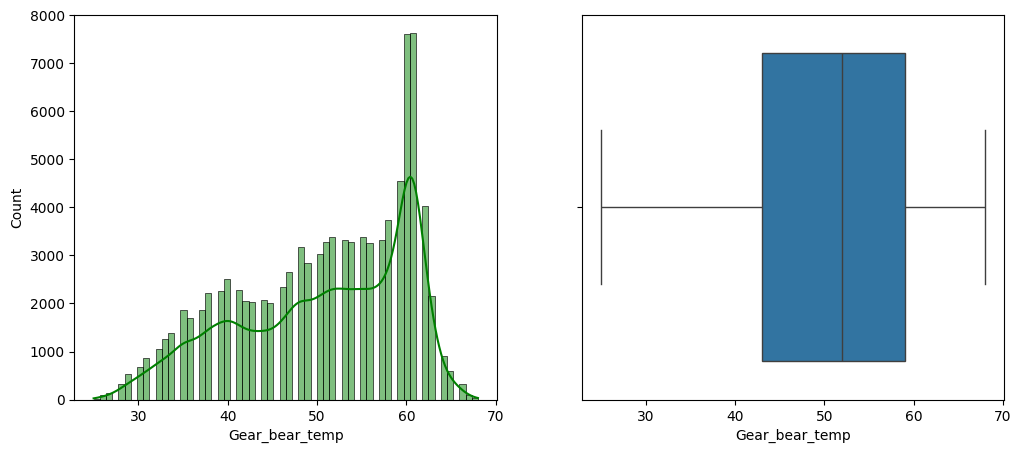

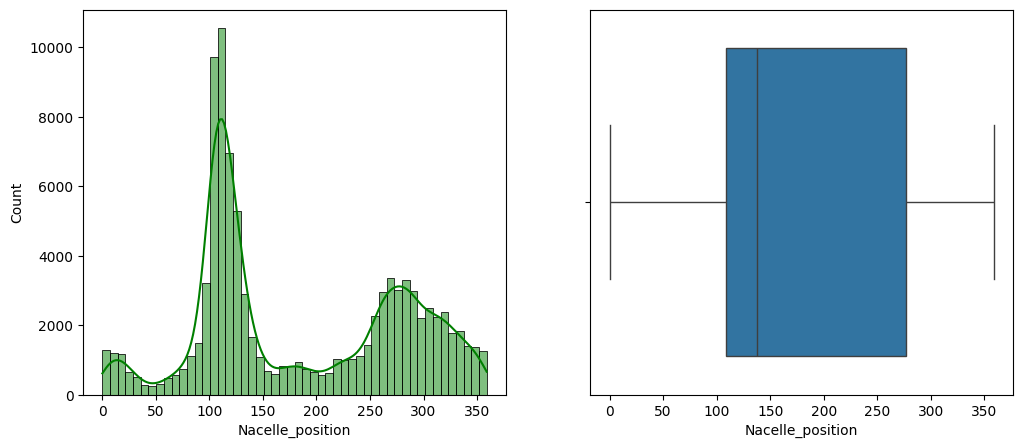

In [ ]:
num_col = ['Wind_speed', 'Wind_speed_std', 'Wind_rel_dir', 'Amb_temp',
           'Gen_speed', 'Gen_speed_std', 'Rotor_speed', 'Rotor_speed_std',
           'Blade_pitch', 'Blade_pitch_std', 'Gen_phase_temp_3', 'Transf_temp_p1',
           'Transf_temp_p2', 'Transf_temp_p3', 'Gen_bearing_temp_1',
           'Gen_bearing_temp_2', 'Hyd_oil_temp', 'Gear_oil_temp', 'Gear_bear_temp',
           'Nacelle_position']

for col in num_col:
    if col == "Timestamp": continue
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(filtered_df[col], kde=True, ax=ax[0], color='green')
    sns.boxplot(x=filtered_df[col], ax=ax[1])
    plt.show()

In [ ]:
df["Month"]

0          1
1          1
2          1
3          1
4          1
          ..
105259    12
105260    12
105261    12
105262    12
105263    12
Name: Month, Length: 105264, dtype: int32

Month


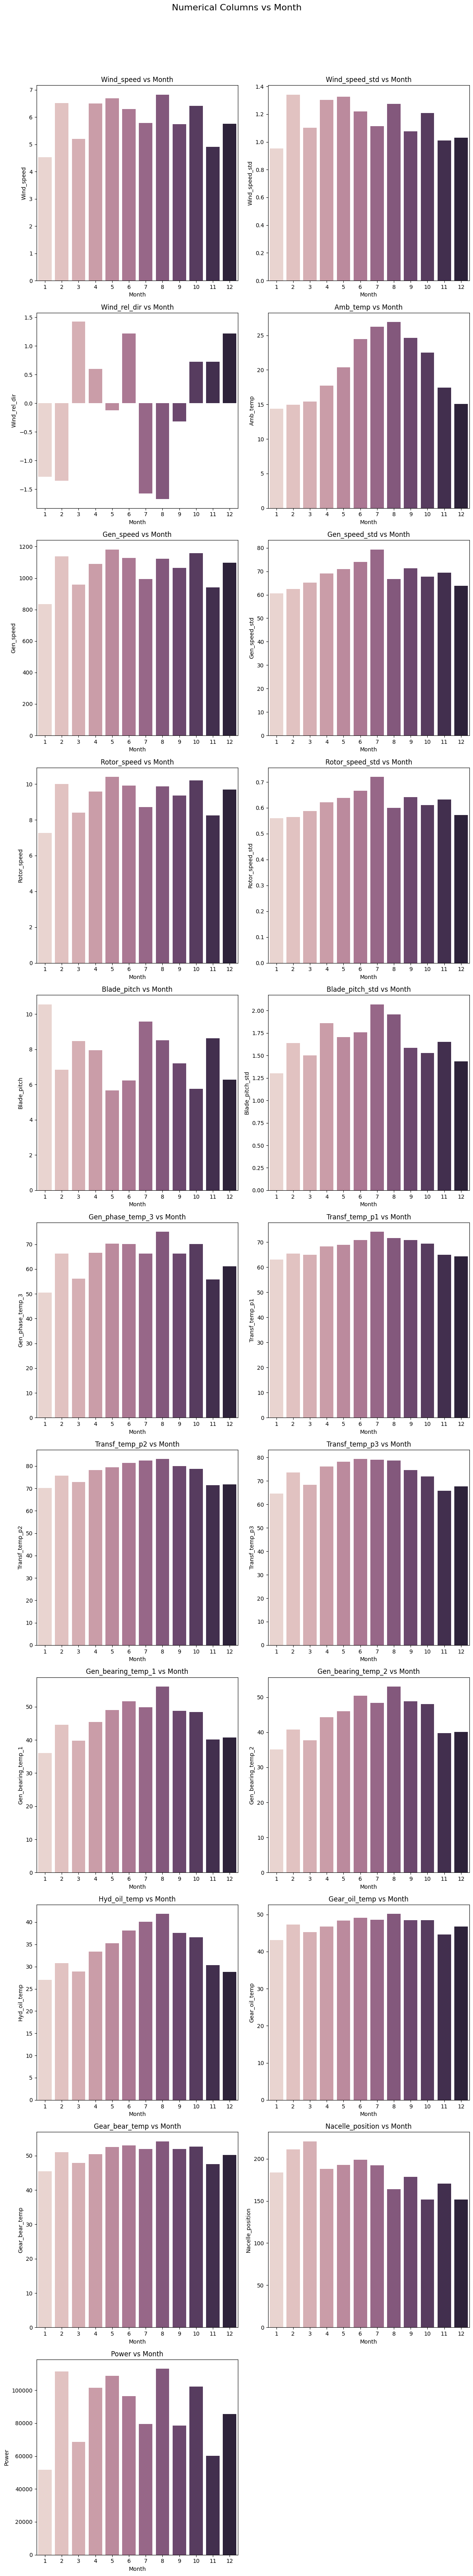

Seasons


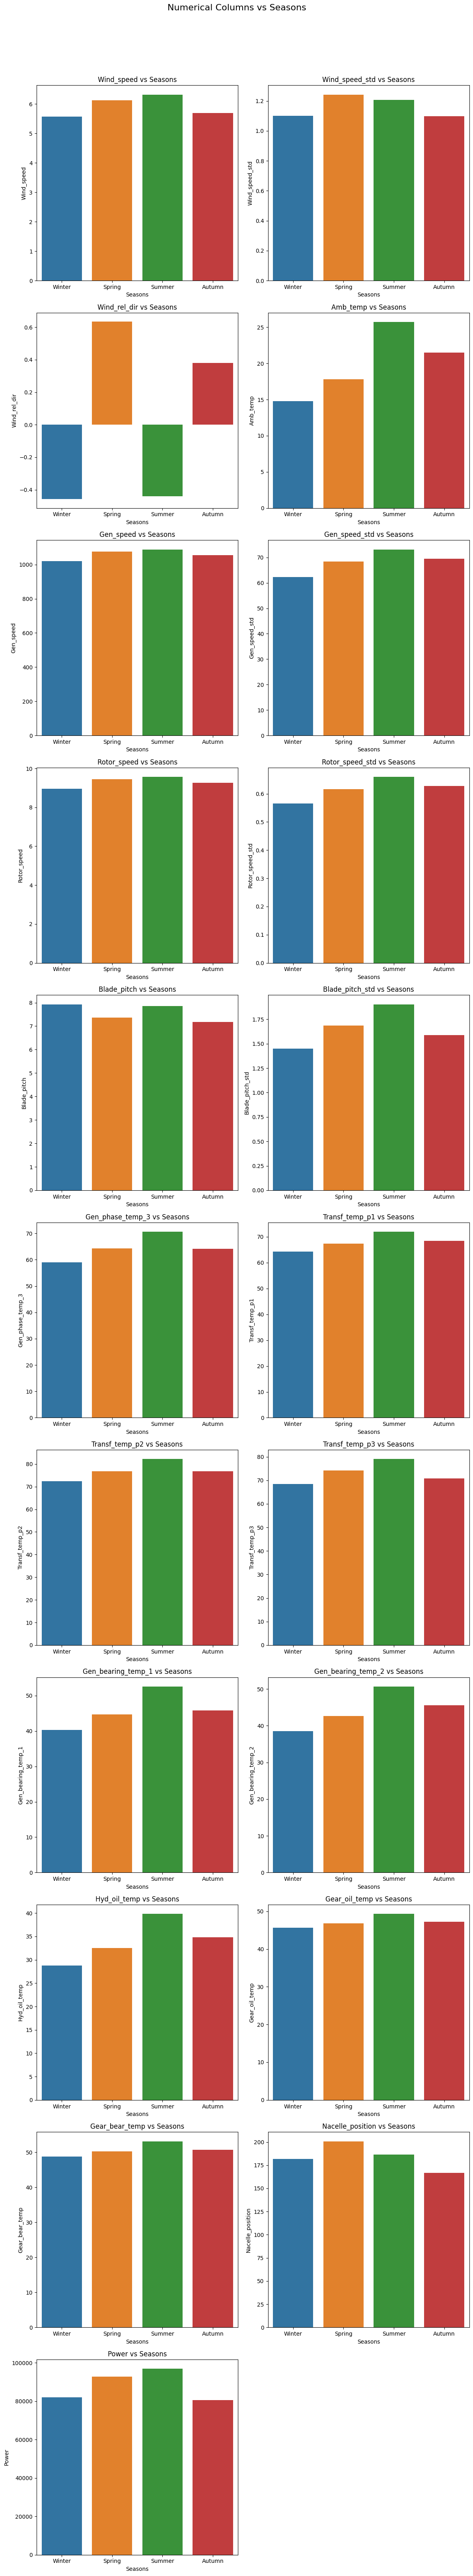

Hour


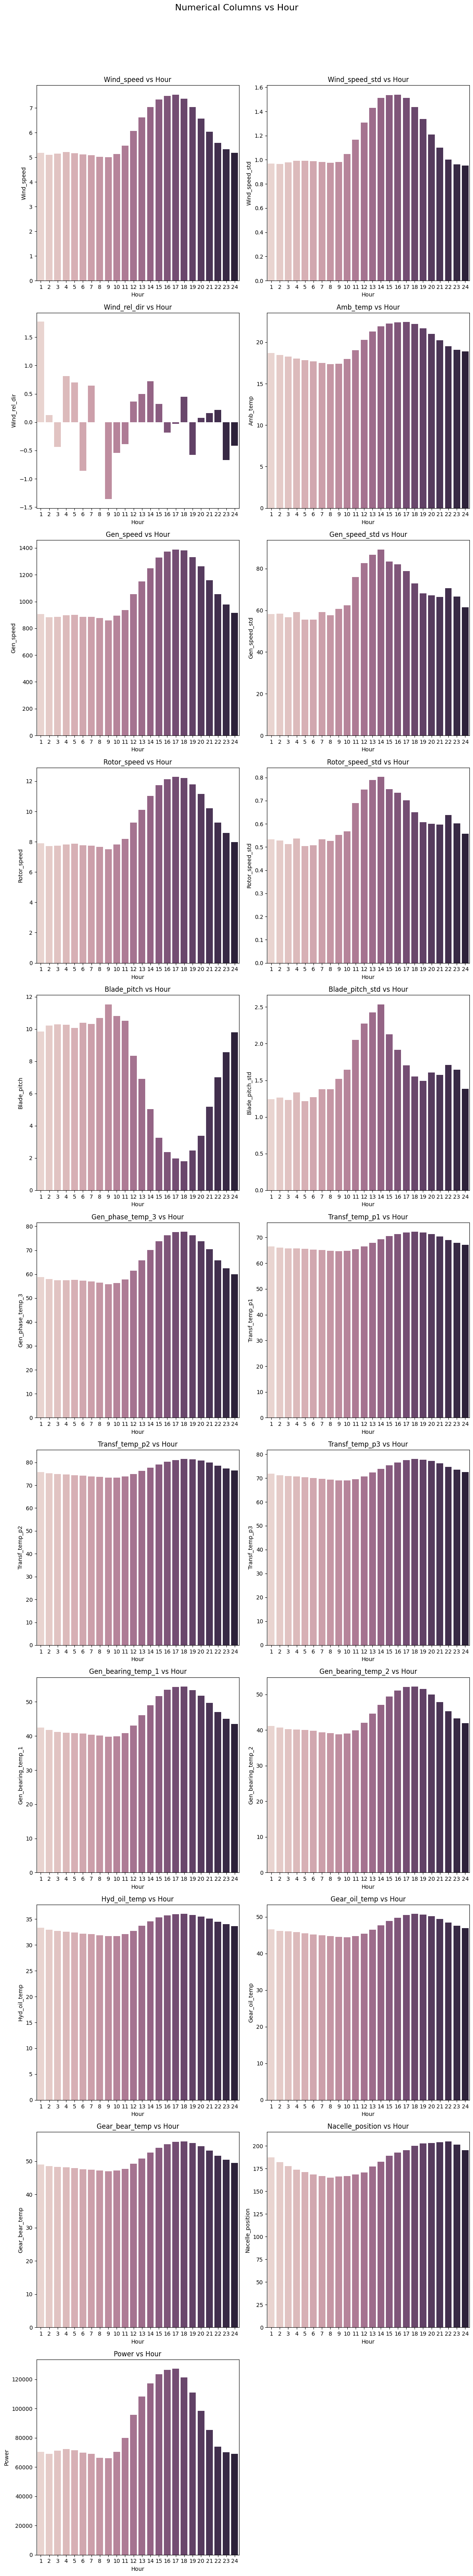

In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure filtered_df is defined or passed as an argument (if it's coming from your dataset)
# filtered_df = your_data_here

date_col = ['Month', 'Seasons', 'Hour']
num_col = ['Wind_speed', 'Wind_speed_std', 'Wind_rel_dir', 'Amb_temp', 
           'Gen_speed', 'Gen_speed_std', 'Rotor_speed', 'Rotor_speed_std',
           'Blade_pitch', 'Blade_pitch_std', 'Gen_phase_temp_3', 'Transf_temp_p1',
           'Transf_temp_p2', 'Transf_temp_p3', 'Gen_bearing_temp_1', 
           'Gen_bearing_temp_2', 'Hyd_oil_temp', 'Gear_oil_temp', 'Gear_bear_temp',
           'Nacelle_position', 'Power']

# Function to create bar plots for numerical columns versus date columns
def create_num_col_vs_date_col(date_col, num_col, df): 
    for date in date_col:
        num_rows = math.ceil(len(num_col) / 2)  # Number of rows needed for subplots
        fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 6 * num_rows))  # Adjusted figsize for readability
        axes = axes.flatten()
        # Loop through numeric features and create individual plots
        for idx, numeric_feature in enumerate(num_col):
            sns.barplot(
                x=date, 
                y=numeric_feature, 
                data=df, 
                ax=axes[idx], 
                errorbar=None, 
                hue=date,  # Add `hue` to use color for the x-axis variable
                legend=False  # Turn off the legend as it's not needed
            )
            axes[idx].set_title(f'{numeric_feature} vs {date}', fontsize=12)

        # Remove unused axes if there are any
        for i in range(len(num_col), len(axes)):
            fig.delaxes(axes[i])

        fig.suptitle(f'Numerical Columns vs {date}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust tight layout to make room for the title
        plt.show()

# Call the function with the filtered dataframe
create_num_col_vs_date_col(date_col, num_col, df)
